# Part 1 - EDA

Load Packages

In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Load 'logins.json' file in to a pandas DataFrame

In [2]:
#load as pandas df
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Aggregate logins based on 15-minute time intervals

In [3]:
df.set_index('login_time', inplace = True)
df['logins'] = 1
df15 = df.resample('15T').apply(sum)

In [4]:
df15 = df15.reset_index()

Creat hour, day and AM/PM columns

In [5]:
#hour
df15['hour'] = df15['login_time'].dt.hour

#day
df15['day'] = df15['login_time'].dt.day_name()

#AM/PM
df15['AM/PM'] = ['AM' if login_time in range(0,12) else 'PM' for login_time in df15['hour']] 

In [6]:
df15.head()

,login_time,logins,hour,day,AM/PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


Determine logins by day

In [7]:
df_days = df15.groupby('day').sum()[['logins']].sort_values(by='logins', ascending=False)
df_days = df_days.reset_index()

In [8]:
df_days

,day,logins
0,Saturday,19377
1,Sunday,18167
2,Friday,15208
3,Thursday,11960
4,Wednesday,10339
5,Tuesday,9268
6,Monday,8823


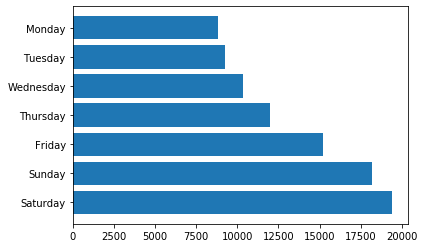

In [9]:
#Data Visualization of logins by day
plt.barh(np.arange(len(df_days.day)), df_days.logins)
plt.yticks(np.arange(len(df_days.day)), df_days.day)

plt.show()

The weekend clearly has the most logins. 

Determine logins by AM/PM

In [10]:
df_ampm = df15.groupby('AM/PM').sum()[['logins']].sort_values(by='logins', ascending=False)
df_ampm = df_ampm.reset_index()

In [11]:
df_ampm

,AM/PM,logins
0,PM,49061
1,AM,44081


([<matplotlib.axis.XTick at 0x103765dd0>,
 <a list of 2 Text xticklabel objects>)

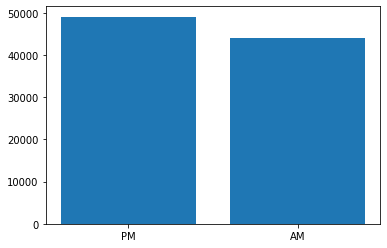

In [12]:
#Visualize AM/PM
plt.bar(np.arange(len(df_ampm['AM/PM'])), df_ampm['logins'])
plt.xticks(np.arange(len(df_ampm['AM/PM'])), df_ampm['AM/PM'])

PM is higher but not by a whole lot.

Determine logins by hour.

In [13]:
df_hour = df15.groupby('hour').sum()[['logins']].sort_values(by='logins', ascending=False)
df_hour = df_hour.reset_index()

In [14]:
df_hour.head()

,hour,logins
0,22,6607
1,1,6317
2,23,6058
3,0,5993
4,2,5800


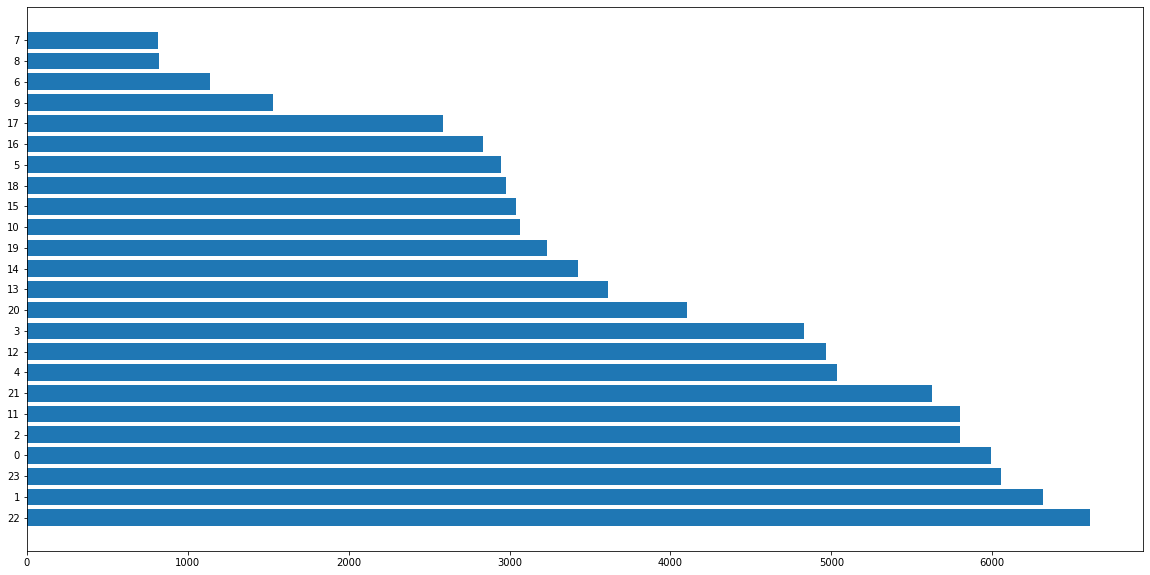

In [15]:
#Data Visualization of logins by hour
plt.figure(figsize=[20,10])
plt.barh(np.arange(len(df_hour.hour)), df_hour.logins)
plt.yticks(np.arange(len(df_hour.hour)), df_hour.hour)

plt.show()

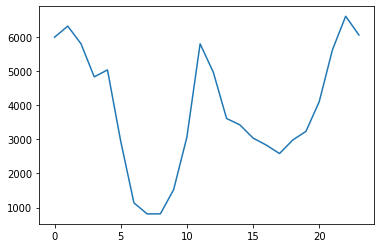

In [16]:
#visualize logins by day, line plot
df_hours = df15.groupby('hour').sum()[['logins']].reset_index()
plt.plot(df_hours.hour, df_hours.logins)

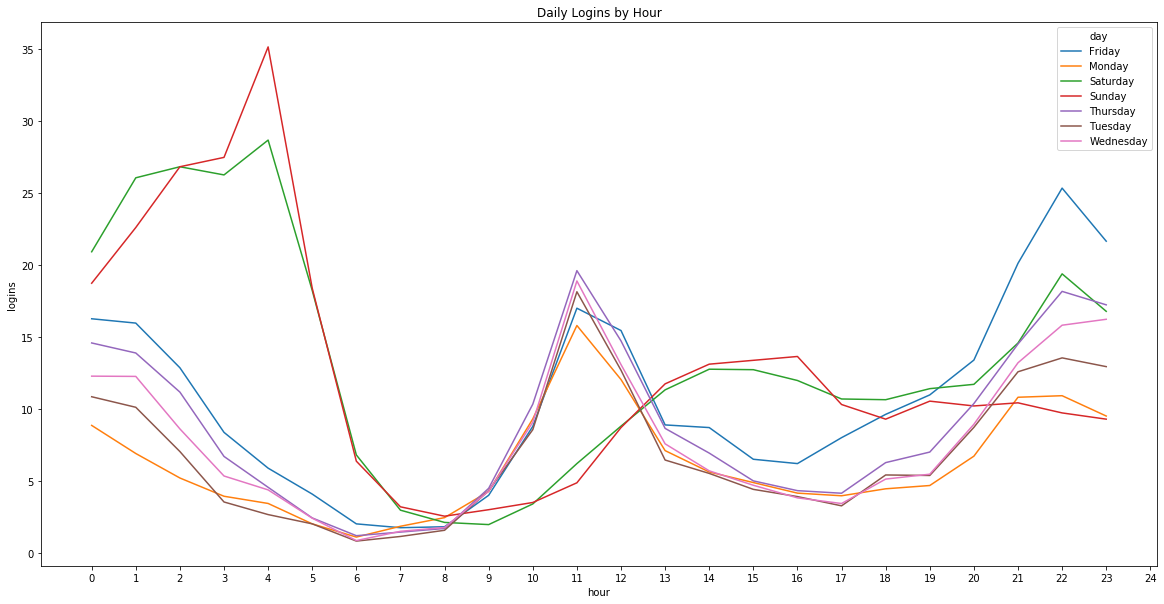

In [17]:
#visualize logins by hour on each day
import seaborn as sns
df_week = df15.groupby(['hour','day']).mean().reset_index()

plt.figure(figsize=[20, 10])
sns.lineplot(x='hour', y='logins', data=df_week, hue = 'day')
plt.legend()
plt.title('Daily Logins by Hour')
plt.xticks(range(0,25))
plt.show()

# Part 2 - Experiment and Metrics Design

1. What would you choose as the key measures of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Since there is a toll bridge, the drivers need incentive to go between cities during peak hours. If the tolls were reimbursed, then driver partners would be encouraged to be active in both cities. Since Metropolis and Gotham are opposite, this would still keep the normal supply during active hours and then additional supply would come from the city that does not have high demand. 


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provde details on:

a. Hou you will implement the experiment
Determine peak hours of demand in each city by seeing the time that has the most riders and seeing the time that has the biggest surge.

b. What statistical tests you will conduct to verify significance of the observation
The riders and surge by time can be correlated

c. How you would interpret the results and provide recommendations to the city operations team along with any caveats
After determining peak times, we can reimburse the the tolls at those to see if more driver partners are available to riders at that time. The surge price can be looked at to see if it goes lower. 

# Part 3 - Predictive Modeling

Import Classifiers

In [62]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [19]:
#load json as string
file = json.load((open('ultimate_data_challenge.json')))

In [20]:
df2 = json_normalize(file)

In [21]:
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Missing values in avg_rating_of_drive, phone and avg_rating_by_drive

1. Determine fraction of the observed users were retained

In [23]:
#change date columns in datetime
df2['signup_date'] = pd.to_datetime(df2['signup_date'])
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [24]:
active = df2[df2['trips_in_first_30_days'] > 0]
active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34610 entries, 0 to 49998
Data columns (total 12 columns):
city                      34610 non-null object
trips_in_first_30_days    34610 non-null int64
signup_date               34610 non-null datetime64[ns]
avg_rating_of_driver      30237 non-null float64
avg_surge                 34610 non-null float64
last_trip_date            34610 non-null datetime64[ns]
phone                     34292 non-null object
surge_pct                 34610 non-null float64
ultimate_black_user       34610 non-null bool
weekday_pct               34610 non-null float64
avg_dist                  34610 non-null float64
avg_rating_by_driver      34503 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.2+ MB


In [25]:
#percentage of retained users
retained = (len(active)/len(df2))*100
print('% Users Retained ' + str(retained) + '%')

% Users Retained 69.22%


2. Build predictive model that helps determine whether or not a user will be active in 6th month on system. 

In [26]:
#create column depicting if user was active after 6 months
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [27]:
from datetime import timedelta

df2['last_trip_first_trip'] = [df2.iloc[i]['last_trip_date'] - df2.iloc[i]['signup_date'] for i in range(len(df2))]
df2['six_month_active'] = [1 if df2.iloc[i]['last_trip_date'] - df2.iloc[i]['signup_date'] > timedelta(days = 30 * 5) else 0 for i in range(len(df2))]

In [29]:
df2.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_first_trip,six_month_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,148 days,0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0,1 days,0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,1 days,0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0,11 days,0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0,2 days,0


In [31]:
#drop datetime columns
df_modeling = df2.drop(columns=['last_trip_date', 'signup_date', 'last_trip_first_trip'])

#search for NaNs
print(df_modeling.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver       True
avg_surge                 False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
six_month_active          False
dtype: bool


In [37]:
#replace NaNs in avg_rating_of_driver and avg_rating_by_drive with mean for column
df_modeling['avg_rating_of_driver'] = df_modeling['avg_rating_of_driver'].fillna(np.mean(df_modeling['avg_rating_of_driver']))

df_modeling['avg_rating_by_driver'] = df_modeling['avg_rating_by_driver'].fillna(np.mean(df_modeling['avg_rating_by_driver']))

In [38]:
print(df_modeling.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver      False
avg_surge                 False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
six_month_active          False
dtype: bool


In [41]:
df_modeling['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [42]:
#replace NaNs in phone with 'Other'
df_modeling['phone'] = df_modeling['phone'].fillna('Other')

In [44]:
#confirm that no columns are missing values now
print(df_modeling.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver      False
avg_surge                 False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
six_month_active          False
dtype: bool


In [46]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
six_month_active          50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


Need to change city, phone and ultimate_black_user to int

In [51]:
df_modeling['ultimate_black_user'] = df_modeling['ultimate_black_user'].astype(int)

df_modeling = pd.get_dummies(df_modeling)

df_modeling.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,six_month_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,0,1,0,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0


In [52]:
X = df_modeling.drop(['six_month_active'], axis=1)
y = df_modeling['six_month_active']

print(X.shape, y.shape)

(50000, 14) (50000,)


In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
trips_in_first_30_days    50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_Other               50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: float64(6), int64(2), uint8(6)
memory usage: 3.3 MB


In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix, classification_report
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [59]:
def predict(X, y, model, params, test_size=0.3, random_state=69):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    crossval = GridSearchCV(model, param_grid=params, cv=5)
    
    crossval.fit(X_train, y_train)
    
    y_pred = crossval.predict(X_test)
    
    y_pred_prob = crossval.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(crossval.best_params_))
    print("Tuned Accuracy Score: {}".format(crossval.best_score_))
    print(classification_report(y_test, y_pred))

### Dummy Classifier

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_score_ypa = dummy.score(X_train, y_train)
print(dummy.score(X_train, y_train))

0.7552


### RandomForest

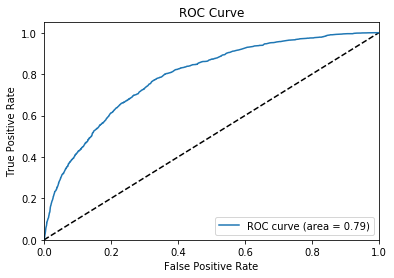

Tuned Hyperparameter(s): {'criterion': 'gini', 'max_depth': 3, 'max_features': 4}
Tuned Accuracy Score: 0.7864857142857142
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     11370
           1       0.67      0.26      0.37      3630

    accuracy                           0.79     15000
   macro avg       0.74      0.61      0.62     15000
weighted avg       0.77      0.79      0.75     15000



In [63]:
rf = RandomForestClassifier()
param_grid_rf = {'max_depth': [3, None], 'max_features' : [1,4,7,10], 'criterion': ['gini', 'entropy']}

predict(X, y, rf, param_grid_rf)

With pretty minimal parameter tuning, the accuracy of our model is 79%.

Will now look at feature importance.

In [66]:
rf = RandomForestClassifier(criterion='gini', max_depth = 3, max_features=4)
rf.fit(X_train, y_train)

importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values(by='feature importance', ascending=False)

In [67]:
importance

,feature importance
avg_rating_by_driver,2.596827e-01
surge_pct,2.162163e-01
avg_surge,1.875918e-01
weekday_pct,1.218433e-01
city_King's Landing,6.565231e-02
phone_iPhone,4.747363e-02
trips_in_first_30_days,3.874832e-02
phone_Android,3.362715e-02
ultimate_black_user,1.977356e-02
city_Astapor,7.667202e-03


Ultimate can leverage insights from the model by looking into ways to decrease surge pricing. It could definitely be solved by increasing the supply of drivers when surges are high. 